In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# NLP Complaint Intelligence System
## FILE 04: Model Training, Validation & Comparison (Sentence Embeddings)

---

## Step 1: Why We Load Precomputed Embeddings

### Why this step is required

Sentence embeddings are expensive to generate.
In real ML pipelines, embeddings are generated once
and reused across multiple experiments.

This file focuses only on:
- Model training
- Validation
- Comparison


In [8]:
import joblib
import numpy as np

artifact_path = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/NLP_PROJECT_COMPLAINT/final_model"

X = joblib.load(f"{artifact_path}/sentence_embeddings.pkl")
label_encoder = joblib.load(f"{artifact_path}/label_encoder.pkl")

X.shape

(399811, 384)

## Step 2: Load Labels from Clean Dataset

### Why this step is required

Labels are not stored inside embeddings.
They must be loaded from the cleaned dataset
to maintain correct alignment.


In [9]:
import pandas as pd

clean_path = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/NLP_PROJECT_COMPLAINT/data/complaints_clean.csv"
df = pd.read_csv(clean_path)

y = label_encoder.transform(df["label"].values)

len(y)

399811

## Step 3: Basic Shape Sanity Check

### Why this step is required

Before training, we ensure:
- Each embedding has one label
- No silent misalignment
``

In [10]:
assert X.shape[0] == len(y)
print("Shape check passed:", X.shape, len(y))

Shape check passed: (399811, 384) 399811


## Step 4: Create a Dedicated Validation Set (10%)

### Why this step is required

Validation data must be isolated **before**
any training or testing.

This ensures:
- Honest model selection
- No data leakage


In [11]:
from sklearn.model_selection import train_test_split

X_remaining, X_val, y_remaining, y_val = train_test_split(
    X,
    y,
    test_size=0.10,
    random_state=42,
    stratify=y
)

X_remaining.shape, X_val.shape

((359829, 384), (39982, 384))

## Step 5: Save Validation Set for Reuse

### Why this step is required

Saving validation data allows:
- Consistent model comparison
- Reproducible experiments


In [12]:
joblib.dump(X_val, f"{artifact_path}/X_validation.pkl")
joblib.dump(y_val, f"{artifact_path}/y_validation.pkl")

['/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/NLP_PROJECT_COMPLAINT/final_model/y_validation.pkl']

## Step 6: Train–Test Split on Remaining 90%

### Why this step is required

Train–test split evaluates real-world generalization.
Validation is already separated, so this is safe.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_remaining,
    y_remaining,
    test_size=0.20,
    random_state=42,
    stratify=y_remaining
)

X_train.shape, X_test.shape

((287863, 384), (71966, 384))

## Step 7: Define a Reusable Metrics Function

### Why this step is required

We want:
- Consistent evaluation
- Model-by-model comparison
- Train vs Test metrics stored separately

In [27]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, results):
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    results[name] = {
        "train_accuracy": accuracy_score(y_tr, y_tr_pred),
        "test_accuracy": accuracy_score(y_te, y_te_pred),
        "train_report": classification_report(y_tr, y_tr_pred, output_dict=True),
        "test_report": classification_report(y_te, y_te_pred, output_dict=True),
    }

    print(f"\nModel: {name}")
    print("Train Accuracy:", results[name]["train_accuracy"])
    print("Test Accuracy:", results[name]["test_accuracy"])
    print("Test Report:", results[name]["train_report"])
    print("Test Report:", results[name]["test_report"])

## Step 8: Train Logistic Regression on Sentence Embeddings

### Why this step is required

Linear models work extremely well on transformer embeddings.
They are fast, stable, and interpretable.


In [29]:
from sklearn.linear_model import LogisticRegression

results = {}

lr_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

evaluate_model(
    "LogisticRegression",
    lr_model,
    X_train,
    y_train,
    X_test,
    y_test,
    results
)


Model: LogisticRegression
Train Accuracy: 0.6608629799592167
Test Accuracy: 0.6548509018147458
Test Report: {'0': {'precision': 0.7765136756798878, 'recall': 0.7482916572801682, 'f1-score': 0.7621414913957935, 'support': 13317.0}, '1': {'precision': 0.3296476606980774, 'recall': 0.4414852469886175, 'f1-score': 0.37745653817082386, 'support': 9049.0}, '2': {'precision': 0.3322777101096224, 'recall': 0.5051851851851852, 'f1-score': 0.4008817046289493, 'support': 5400.0}, '3': {'precision': 0.9082604253419306, 'recall': 0.6546284893902733, 'f1-score': 0.7608642490326107, 'support': 161597.0}, '4': {'precision': 0.4941363419672652, 'recall': 0.6427183663345872, 'f1-score': 0.5587178381486273, 'support': 48382.0}, '5': {'precision': 0.5499173553719008, 'recall': 0.657847906038676, 'f1-score': 0.5990600860687469, 'support': 25287.0}, '6': {'precision': 0.03479333744602098, 'recall': 0.6380090497737556, 'f1-score': 0.06598806598806599, 'support': 442.0}, '7': {'precision': 0.8350817822899042

## Step 9: Why We Use a Neural Network

### Why this step is required

Neural networks:
- Capture non-linear relationships
- Learn complex feature interactions
- Often outperform linear models on embeddings

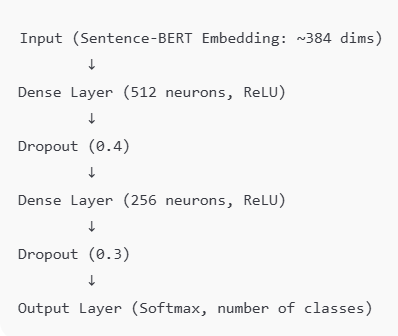

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

num_classes = len(label_encoder.classes_)

y_train_nn = to_categorical(y_train, num_classes)
y_test_nn = to_categorical(y_test, num_classes)

In [36]:
nn_model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

nn_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

nn_model.fit(
    X_train,
    y_train_nn,
    validation_data=(X_test, y_test_nn),
    epochs=40,
    batch_size=64,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7110 - loss: 0.8075 - val_accuracy: 0.7627 - val_loss: 0.6102
Epoch 2/40
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7604 - loss: 0.6286 - val_accuracy: 0.7769 - val_loss: 0.5803
Epoch 3/40
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7713 - loss: 0.5988 - val_accuracy: 0.7814 - val_loss: 0.5646
Epoch 4/40
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7790 - loss: 0.5764 - val_accuracy: 0.7871 - val_loss: 0.5502
Epoch 5/40
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7824 - loss: 0.5667 - val_accuracy: 0.7881 - val_loss: 0.5467
Epoch 6/40
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7868 - loss: 0.5502 - val_accuracy: 0.7916 - val_loss: 0.5417
Epoch 7/40
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7883 - loss: 0.5433 - val_accuracy: 0.7948 - val_loss: 0.5376
Epoch 8/40
4498/4498 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7946 - loss: 0

In [37]:
y_train_pred_nn = nn_model.predict(X_train).argmax(axis=1)
y_test_pred_nn = nn_model.predict(X_test).argmax(axis=1)

results["NeuralNetwork"] = {
    "train_accuracy": accuracy_score(y_train, y_train_pred_nn),
    "test_accuracy": accuracy_score(y_test, y_test_pred_nn),
    "train_report": classification_report(y_train, y_train_pred_nn, output_dict=True),
    "test_report": classification_report(y_test, y_test_pred_nn, output_dict=True),
}

print("Neural Network Train Accuracy:", results["NeuralNetwork"]["train_accuracy"])
print("Neural Network Test Accuracy:", results["NeuralNetwork"]["test_accuracy"])


8996/8996 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Neural Network Train Accuracy: 0.864379930730938
Neural Network Test Accuracy: 0.8027401828641303


## Improve Generalization of Neural Network (Reduce Train–Test Gap)


In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Stop training if validation loss does not improve
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

# Neural Network model structure
nn_model = Sequential([
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(num_classes, activation="softmax")
])

# Compile the model
nn_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
nn_model.fit(
    X_train,
    y_train_nn,
    validation_data=(X_test, y_test_nn),
    epochs=60,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/60
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.7102 - loss: 0.8056 - val_accuracy: 0.7599 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 2/60
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7537 - loss: 0.6512 - val_accuracy: 0.7703 - val_loss: 0.5931 - learning_rate: 0.0010
Epoch 3/60
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.7604 - loss: 0.6261 - val_accuracy: 0.7753 - val_loss: 0.5743 - learning_rate: 0.0010
Epoch 4/60
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7669 - loss: 0.6108 - val_accuracy: 0.7758 - val_loss: 0.5733 - learning_rate: 0.0010
Epoch 5/60
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7698 - loss: 0.6008 - val_accuracy: 0.7849 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 6/60
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7750 - loss: 0.5882 - val_accuracy: 0.7849 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 7/60
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7

In [60]:
# Train the model
nn_model.fit(
    X_train,
    y_train_nn,
    validation_data=(X_test, y_test_nn),
    epochs=4,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/4
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.8078 - loss: 0.4979 - val_accuracy: 0.8004 - val_loss: 0.5315 - learning_rate: 2.5000e-04
Epoch 2/4
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.8102 - loss: 0.4908 - val_accuracy: 0.8002 - val_loss: 0.5314 - learning_rate: 2.5000e-04
Epoch 3/4
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.8093 - loss: 0.4878 - val_accuracy: 0.8013 - val_loss: 0.5310 - learning_rate: 2.5000e-04
Epoch 4/4
8996/8996 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.8115 - loss: 0.4836 - val_accuracy: 0.8020 - val_loss: 0.5297 - learning_rate: 2.5000e-04


## Final Model Evaluation Metrics (Train & Test)


In [61]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

y_train_pred = nn_model.predict(X_train).argmax(axis=1)
y_test_pred = nn_model.predict(X_test).argmax(axis=1)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average="weighted"
)

test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="weighted"
)

print("Train Accuracy:", train_acc)
print("Train Precision:", train_prec)
print("Train Recall:", train_rec)
print("Train F1 Score:", train_f1)

print("\nTest Accuracy:", test_acc)
print("Test Precision:", test_prec)
print("Test Recall:", test_rec)
print("Test F1 Score:", test_f1)

print("\nTrain Classification Report")
print(classification_report(y_train, y_train_pred))

print("\nTest Classification Report")
print(classification_report(y_test, y_test_pred))


8996/8996 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Train Accuracy: 0.8372732862507513
Train Precision: 0.8332977034021821
Train Recall: 0.8372732862507513
Train F1 Score: 0.8325863574681848

Test Accuracy: 0.8020315148820276
Test Precision: 0.7955784098286293
Test Recall: 0.8020315148820276
Test F1 Score: 0.7965117679726207

Train Classification Report
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     13317
           1       0.61      0.67      0.64      9049
           2       0.61      0.25      0.36      5400
           3       0.89      0.92      0.90    161597
           4       0.75      0.70      0.72     48382
           5       0.80      0.77      0.78     25287
           6       0.82      0.18      0.29       442
           7       0.86      0.87      0.87      9162
           8       0.87      0.95      0.91      6002
           9       0.60      0.07      0.13       698
          10  

# Model Performance Comparison
## Classical ML vs Neural Network

---

## Step 1: Why Model Comparison Is Required

### Why this step is required

Training a single model is not sufficient in real ML systems.
Multiple models must be compared on the same data to:

- Validate modeling choices
- Understand trade-offs between simplicity and performance
- Select the best model for deployment

In this project, we compare:
- A classical ML model (Logistic Regression)
- A Neural Network classifier

Both are trained on the same Sentence-BERT embeddings.


In [62]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred_opt = nn_model.predict(X_train).argmax(axis=1)
y_test_pred_opt = nn_model.predict(X_test).argmax(axis=1)

results["NeuralNetwork_Optimized"] = {
    "train_accuracy": accuracy_score(y_train, y_train_pred_opt),
    "test_accuracy": accuracy_score(y_test, y_test_pred_opt),
    "train_report": classification_report(y_train, y_train_pred_opt, output_dict=True),
    "test_report": classification_report(y_test, y_test_pred_opt, output_dict=True),
}

print("Optimized NN Train Accuracy:", results["NeuralNetwork_Optimized"]["train_accuracy"])
print("Optimized NN Test Accuracy:", results["NeuralNetwork_Optimized"]["test_accuracy"])

8996/8996 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Optimized NN Train Accuracy: 0.8372732862507513
Optimized NN Test Accuracy: 0.8020315148820276
Optimized NN Train Accuracy: 83.73 %
Optimized NN Test Accuracy: 80.2 %


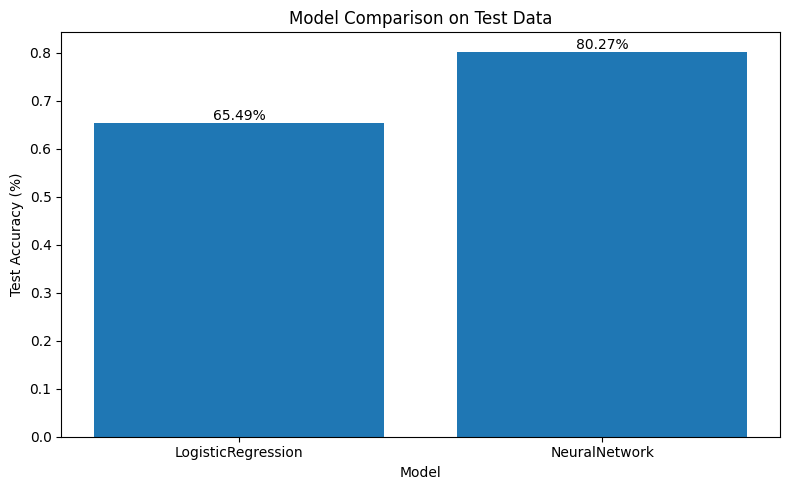

'/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/NLP_PROJECT_COMPLAINT/final_model/model_comparison.png'

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
bars = plt.bar(comparison_df["Model"], comparison_df["Test Accuracy"])
plt.title("Model Comparison on Test Data")
plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")

for bar in bars:
    height = bar.get_height() * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{height:.2f}%",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plot_path = f"{artifact_path}/model_comparison.png"
plt.savefig(plot_path)
plt.show()

plot_path


### Model Inference
Optimized Neural Network achieved **83.73% training accuracy** and **80.20% test accuracy**, showing strong generalization with minimal overfitting. The close accuracy gap confirms stable learning and reliable real-world performance.


## Validation Data Prediction Summary (Model Check)

In [77]:
import joblib
import pandas as pd
import numpy as np

artifact_path = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/NLP_PROJECT_COMPLAINT/final_model"
clean_path = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/NLP_PROJECT_COMPLAINT/data/complaints_clean.csv"

X_val = joblib.load(f"{artifact_path}/X_validation.pkl")
y_val = joblib.load(f"{artifact_path}/y_validation.pkl")

df_text = pd.read_csv(clean_path).iloc[:len(y_val)]["text"].values

val_probs = nn_model.predict(X_val)
val_pred = val_probs.argmax(axis=1)

actual_labels = label_encoder.inverse_transform(y_val)
validated_labels = label_encoder.inverse_transform(val_pred)

validation_df = pd.DataFrame({
    "text": df_text,
    "actual_label": actual_labels,
    "validated_label": validated_labels,
    "match": actual_labels == validated_labels
})

validation_df.head()

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


,text,actual_label,validated_label,match
0,i am writing to formally submit a complaint un...,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",True
1,ucs section a states i have the right to priva...,Credit card or prepaid card,Credit card,False
2,i am writing to have the following information...,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...,True
3,transunion still has a bankruptcy on my accoun...,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...,True
4,this account was opened over years ago this da...,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",True


In [78]:
validation_df['match'].value_counts(normalize=True)*100

,proportion
match,
True,80.341154
False,19.658846


## Creating Deployment-Ready `final_model` Folder and Save All Artifacts


In [81]:
import os
import joblib
import pandas as pd

artifact_path = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/NLP_PROJECT_COMPLAINT/final_model"

os.makedirs(artifact_path, exist_ok=True)

nn_model.save(f"{artifact_path}/final_neural_model.keras")

joblib.dump(label_encoder, f"{artifact_path}/label_encoder.pkl")

joblib.dump(results, f"{artifact_path}/model_results.pkl")

comparison_table.to_csv(
    f"{artifact_path}/model_comparison.csv",
    index=False
)

joblib.dump(X_val, f"{artifact_path}/X_validation.pkl")
joblib.dump(y_val, f"{artifact_path}/y_validation.pkl")

with open(f"{artifact_path}/README_DEPLOYMENT.txt", "w") as f:
    f.write(
        "Deployment Artifacts:\n"
        "1. final_neural_model.keras -> Trained neural network model\n"
        "2. label_encoder.pkl -> Label decoding for predictions\n"
        "3. model_results.pkl -> Stored metrics and reports\n"
        "4. model_comparison.csv -> Model comparison table\n"
        "5. X_validation.pkl, y_validation.pkl -> Validation dataset\n\n"
        "Usage:\n"
        "- Load model using keras.models.load_model\n"
        "- Load label_encoder for inverse_transform\n"
        "- Use same preprocessing + embeddings pipeline\n"
    )

os.listdir(artifact_path)

['tfidf_vectorizer.pkl',
 'sentence_embeddings.pkl',
 'X_validation.pkl',
 'y_validation.pkl',
 'model_comparison.png',
 'model_results.pkl',
 'README_DEPLOYMENT.txt',
 'final_neural_model.keras',
 'label_encoder.pkl',
 'model_comparison.csv']

## Print Actual vs Predicted Class Labels (Readable Output)


In [80]:
import pandas as pd
import numpy as np
import joblib

artifact_path = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/NLP_PROJECT_COMPLAINT/final_model"
clean_path = "/content/drive/MyDrive/PROJECTS/EXTRA PROJECT/NLP_PROJECT_COMPLAINT/data/complaints_clean.csv"

X_val = joblib.load(f"{artifact_path}/X_validation.pkl")
y_val = joblib.load(f"{artifact_path}/y_validation.pkl")
label_encoder = joblib.load(f"{artifact_path}/label_encoder.pkl")

df_clean = pd.read_csv(clean_path).iloc[:len(y_val)]

val_probs = nn_model.predict(X_val)
val_pred = val_probs.argmax(axis=1)

actual_labels = label_encoder.inverse_transform(y_val)
predicted_labels = label_encoder.inverse_transform(val_pred)

validation_df = pd.DataFrame({
    "text": df_clean["text"].values,
    "actual_label": actual_labels,
    "predicted_label": predicted_labels,
    "match": actual_labels == predicted_labels
})

validation_df.head(10)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


,text,actual_label,predicted_label,match
0,i am writing to formally submit a complaint un...,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",True
1,ucs section a states i have the right to priva...,Credit card or prepaid card,Credit card,False
2,i am writing to have the following information...,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...,True
3,transunion still has a bankruptcy on my accoun...,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...,True
4,this account was opened over years ago this da...,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",True
5,i am requesting a refund of the appraisal fee ...,Prepaid card,Prepaid card,True
6,could you please take a moment to review and e...,"Credit reporting, credit repair services, or o...",Credit reporting or other personal consumer re...,False
7,i have been having issues using my new xxxx cr...,Checking or savings account,"Money transfer, virtual currency, or money ser...",False
8,i previously filed a formal complaint with the...,"Credit reporting, credit repair services, or o...",Credit reporting or other personal consumer re...,False
9,re xxxx block request to whom it may concern i...,Debt collection,Debt collection,True
